# Objectives

✅ Extract, process, and analyze crisis-related discussions from social media \
✅ Apply sentiment analysis and NLP techniques to assess high-risk content \
✅ Geocode and visualize crisis-related trends on a basic interactive map

## Task 1: Twitter a Data Extraction & Preprocessing

### Step 1: Setup and Import

In [1]:
# Import Libraries
import requests
import pandas as pd
import re
import string
import time
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

#nltk.download('stopwords')
#nltk.download('punkt')

### Step 2: API

In [2]:
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAEyt0AEAAAAAJOamnHIHsJiNA2kG8%2FQn3q2XPBQ%3DIPPbbMi85m3u4l9tKlcay5njkrCHsVvuLHy5LIEGWdRyE1X9bT'

headers = {
    "Authorization": f"Bearer {BEARER_TOKEN}"
}

### Step 3: Define Keywords and Search Function

In [3]:
# Define keywords

keywords = [
    "depressed", "suicidal", "anxiety", "overwhelmed", "mental health", "panic attack", "addiction", "relapse", "lonely", "can' go on",
    "need help", "worthless", "hopeless", "hurting", "crying"
]

In [4]:
# Search Query

query = " OR ".join([f'"{kw}"' for kw in keywords]) + " lang:en -is:retweet"

In [5]:
# Search Function

def search_tweets(query, max_results = 50):
    url = "https://api.twitter.com/2/tweets/search/recent"
    params = {
        'query': query,
        'tweet.fields': 'id,text,created_at,public_metrics',
        'max_results': max_results
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error:", response.json())
    return response.json().get('data', [])

### Step 4: Extract and Store Tweet

In [6]:
tweets = search_tweets(query)
print(f"Retrieved {len(tweets)} tweets")

Retrieved 50 tweets


In [7]:
# Store in DataFrame

df_raw = pd.DataFrame([
    {
        "id": tweet['id'],
        "timestamp": tweet['created_at'],
        "text": tweet['text'],
        "likes": tweet['public_metrics']['like_count'],
        "retweet": tweet['public_metrics']['retweet_count'],
        "replies": tweet['public_metrics']['reply_count'],
        "quotes": tweet['public_metrics']['quote_count']
    }
    for tweet in tweets
])

In [8]:
df_raw.to_csv("raw_tweets.csv", index = False)
df_raw.head()

,id,timestamp,text,likes,retweet,replies,quotes
0,1904555274326683879,2025-03-25T15:25:36.000Z,"@Tigermanzoo ""yeah, guns can wait until he wak...",0,0,0,0
1,1904555273823334779,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0
2,1904555273785651278,2025-03-25T15:25:36.000Z,✅ Accessibility for All – Physical accommodati...,0,0,1,0
3,1904555273588535445,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0
4,1904555273466830908,2025-03-25T15:25:36.000Z,I saw a baby goat on the side of the road whil...,0,0,0,0


### Step 5: Clean Text

In [12]:
stop_words = set(stopwords.words("english"))

In [19]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # Chinese characters
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

In [20]:
def clean_text(text):
    # lowercase
    text = text.lower()
    # remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags = re.MULTILINE)
    # Remove punctuation and emojis
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = remove_emojis(text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

In [21]:
df_raw["cleaned_text"] = df_raw["text"].apply(clean_text)
df_raw.to_csv("cleaned_tweets.csv", index=False)
df_raw[["text", "cleaned_text"]].head()

,text,cleaned_text
0,"@Tigermanzoo ""yeah, guns can wait until he wak...",tigermanzoo yeah guns wait wakes probably wont...
1,RT @libsoftiktok: We have a serious mental hea...,rt libsoftiktok serious mental health crisis c...
2,✅ Accessibility for All – Physical accommodati...,accessibility – physical accommodations assist...
3,RT @libsoftiktok: We have a serious mental hea...,rt libsoftiktok serious mental health crisis c...
4,I saw a baby goat on the side of the road whil...,saw baby goat side road patrol crying leg look...


## Task 2: Sentiment & Crisis Risk Classification

### Step 1: Set Up and Import

In [36]:
# !pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Step 2: Load Clean Data

In [24]:
df = pd.read_csv('cleaned_tweets.csv')
df = df.dropna(subset = ["cleaned_text"])
df = df[df["cleaned_text"].str.strip() != ""]
df.reset_index(drop = True, inplace = True)
df.head()

,id,timestamp,text,likes,retweet,replies,quotes,cleaned_text
0,1904555274326683879,2025-03-25T15:25:36.000Z,"@Tigermanzoo ""yeah, guns can wait until he wak...",0,0,0,0,tigermanzoo yeah guns wait wakes probably wont...
1,1904555273823334779,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...
2,1904555273785651278,2025-03-25T15:25:36.000Z,✅ Accessibility for All – Physical accommodati...,0,0,1,0,accessibility – physical accommodations assist...
3,1904555273588535445,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...
4,1904555273466830908,2025-03-25T15:25:36.000Z,I saw a baby goat on the side of the road whil...,0,0,0,0,saw baby goat side road patrol crying leg look...


### Step 3: Sentiment Analysis with VADER

In [25]:
analyzer = SentimentIntensityAnalyzer()

In [26]:
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= - 0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['cleaned_text'].apply(get_sentiment)

In [29]:
df.head(10)

,id,timestamp,text,likes,retweet,replies,quotes,cleaned_text,sentiment
0,1904555274326683879,2025-03-25T15:25:36.000Z,"@Tigermanzoo ""yeah, guns can wait until he wak...",0,0,0,0,tigermanzoo yeah guns wait wakes probably wont...,Negative
1,1904555273823334779,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...,Negative
2,1904555273785651278,2025-03-25T15:25:36.000Z,✅ Accessibility for All – Physical accommodati...,0,0,1,0,accessibility – physical accommodations assist...,Positive
3,1904555273588535445,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...,Negative
4,1904555273466830908,2025-03-25T15:25:36.000Z,I saw a baby goat on the side of the road whil...,0,0,0,0,saw baby goat side road patrol crying leg look...,Negative
5,1904555272435384616,2025-03-25T15:25:36.000Z,RT @danielwayne37: ala sial la mentang dia cin...,0,717,0,0,rt danielwayne ala sial la mentang dia cina bu...,Positive
6,1904555270535098531,2025-03-25T15:25:36.000Z,@WhitKors @hananazizi77 Hope was resigned to t...,1,0,0,0,whitkors hananazizi hope resigned fact got fir...,Negative
7,1904555270497321373,2025-03-25T15:25:36.000Z,RT @LexaproTrader: That anxiety inducing momen...,0,3,0,0,rt lexaprotrader anxiety inducing moment wake ...,Negative
8,1904555269650002136,2025-03-25T15:25:35.000Z,RT @HenpeckedHal: me: did you ask the kids to ...,0,13,0,0,rt henpeckedhal ask kids organize legos brick ...,Negative
9,1904555268681470401,2025-03-25T15:25:35.000Z,RT @paraschopra: Doubting yourself is how you ...,0,123,0,0,rt paraschopra doubting increase odds making g...,Positive


### Step 3: Risk Classification

In [32]:
high_risk_terms = [
    'suicidal', 'kill myself', 'die', "don't want to live", 'overdose', 
    'I want to end it', 'end my life', "i can't go on"
]

moderate_terms = [
    'depressed', 'panic', 'anxiety', 'crying', 'worthless', 'lonley',
    'ned help', 'relapse', 'hurting', 'overwhelmed'
]

In [33]:
def classify_risk(text):
    text = text.lower()
    if any(term in text for term in high_risk_terms):
        return "High Risk"
    elif any(term in text for term in moderate_terms):
        return "Moderate Concern"
    else:
        return "Low Concern"

df["risk level"] = df['cleaned_text'].apply(classify_risk)

In [34]:
df.head(10)

,id,timestamp,text,likes,retweet,replies,quotes,cleaned_text,sentiment,risk level
0,1904555274326683879,2025-03-25T15:25:36.000Z,"@Tigermanzoo ""yeah, guns can wait until he wak...",0,0,0,0,tigermanzoo yeah guns wait wakes probably wont...,Negative,Moderate Concern
1,1904555273823334779,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...,Negative,Low Concern
2,1904555273785651278,2025-03-25T15:25:36.000Z,✅ Accessibility for All – Physical accommodati...,0,0,1,0,accessibility – physical accommodations assist...,Positive,Low Concern
3,1904555273588535445,2025-03-25T15:25:36.000Z,RT @libsoftiktok: We have a serious mental hea...,0,266,0,0,rt libsoftiktok serious mental health crisis c...,Negative,Low Concern
4,1904555273466830908,2025-03-25T15:25:36.000Z,I saw a baby goat on the side of the road whil...,0,0,0,0,saw baby goat side road patrol crying leg look...,Negative,Moderate Concern
5,1904555272435384616,2025-03-25T15:25:36.000Z,RT @danielwayne37: ala sial la mentang dia cin...,0,717,0,0,rt danielwayne ala sial la mentang dia cina bu...,Positive,Low Concern
6,1904555270535098531,2025-03-25T15:25:36.000Z,@WhitKors @hananazizi77 Hope was resigned to t...,1,0,0,0,whitkors hananazizi hope resigned fact got fir...,Negative,Moderate Concern
7,1904555270497321373,2025-03-25T15:25:36.000Z,RT @LexaproTrader: That anxiety inducing momen...,0,3,0,0,rt lexaprotrader anxiety inducing moment wake ...,Negative,Moderate Concern
8,1904555269650002136,2025-03-25T15:25:35.000Z,RT @HenpeckedHal: me: did you ask the kids to ...,0,13,0,0,rt henpeckedhal ask kids organize legos brick ...,Negative,Moderate Concern
9,1904555268681470401,2025-03-25T15:25:35.000Z,RT @paraschopra: Doubting yourself is how you ...,0,123,0,0,rt paraschopra doubting increase odds making g...,Positive,Low Concern


In [54]:
df.to_csv("task2_sentiment_risk.csv", index=False)

### Step 4: TF-IDF Top Terms per Risk Category

In [41]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df["cleaned_text"])
feature_names = vectorizer.get_feature_names_out()


In [45]:
def top_tfidf_words(df_subset, n=10):
    X_sub = vectorizer.transform(df_subset["cleaned_text"])
    tfidf_means = np.asarray(X_sub.mean(axis=0)).flatten()
    top_indices = tfidf_means.argsort()[::-1][:n]
    return [(feature_names[i], round(tfidf_means[i], 3)) for i in top_indices]

top_terms = {
    level: top_tfidf_words(df[df["risk level"] == level])
    for level in df["risk level"].unique()
}

for level, terms in top_terms.items():
    print(f"\nTop TF-IDF terms for {level}: \n")
    for word, score in terms:
        print(f"{word}: {score}")


Top TF-IDF terms for Moderate Concern: 

crying: 0.112
anxiety: 0.057
rt: 0.053
like: 0.052
worthless: 0.04
im: 0.039
depressed: 0.034
fucking: 0.028
ask: 0.026
work: 0.025

Top TF-IDF terms for Low Concern: 

health: 0.125
mental: 0.119
country: 0.084
libsoftiktok: 0.084
crisis: 0.084
rt: 0.078
lonely: 0.048
help: 0.036
amp: 0.034
nz: 0.033

Top TF-IDF terms for High Risk: 

sober: 0.279
usero: 0.279
suicidal: 0.279
rt: 0.192
cancer: 0.142
screenings: 0.142
hospitals: 0.142
elderly: 0.142
canceled: 0.142
lost: 0.142


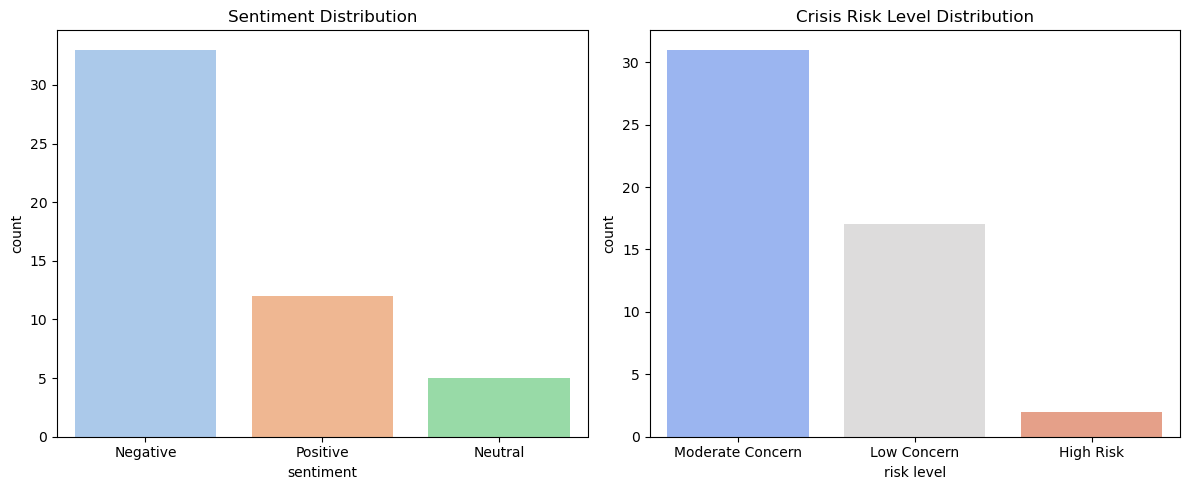

In [49]:
plt.figure(figsize=(12, 5))

# Sentiment plot
plt.subplot(1, 2, 1)
sns.countplot(data = df, x = "sentiment", hue = "sentiment", palette = "pastel", legend = False)
plt.title("Sentiment Distribution")

# Risk level plot
plt.subplot(1, 2, 2)
sns.countplot(data = df, x = "risk level", hue = "risk level", palette = "coolwarm", legend = False)
plt.title("Crisis Risk Level Distribution")

plt.tight_layout()
plt.show()

## Task 3: Crisis Geolocation & Heatmap Visualization

### Step 1: Recollect Data with User Location

In [59]:
def search_tweets(query, max_results=50):
    url = "https://api.twitter.com/2/tweets/search/recent"
    params = {
        'query': query,
        'tweet.fields': 'id,text,created_at,public_metrics,author_id',
        'user.fields': 'location',
        'expansions': 'author_id',
        'max_results': max_results
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        print("Error:", response.json())
        return []
    data = response.json()
    
    # Extract users and link them by author_id
    users = {u["id"]: u.get("location", None) for u in data.get("includes", {}).get("users", [])}
    
    tweets = []
    for tweet in data.get("data", []):
        tweet_data = {
            "id": tweet["id"],
            "timestamp": tweet["created_at"],
            "text": tweet["text"],
            "likes": tweet["public_metrics"]["like_count"],
            "retweets": tweet["public_metrics"]["retweet_count"],
            "replies": tweet["public_metrics"]["reply_count"],
            "quotes": tweet["public_metrics"]["quote_count"],
            "user_location": users.get(tweet["author_id"], None)
        }
        tweets.append(tweet_data)
    
    return tweets

In [60]:
tweets = search_tweets(query)
print(f"Retrieved {len(tweets)} tweets")

Retrieved 50 tweets


In [61]:
tweets

[{'id': '1904733682960916616',
  'timestamp': '2025-03-26T03:14:32.000Z',
  'text': 'uda hopeless bangett rasanyaa, capee harus mikirin semuanyaa https://t.co/2MsbFlJEIE',
  'likes': 0,
  'retweets': 0,
  'replies': 0,
  'quotes': 0,
  'user_location': None},
 {'id': '1904733682591846578',
  'timestamp': '2025-03-26T03:14:32.000Z',
  'text': "@Thunder__OW I don't need help to gain rank I'm not an egirl",
  'likes': 0,
  'retweets': 0,
  'replies': 0,
  'quotes': 0,
  'user_location': None},
 {'id': '1904733682578977043',
  'timestamp': '2025-03-26T03:14:32.000Z',
  'text': "New anxiety tick just dropped, I'm using tweezers to pull out my facial hair instead of biting my nails.",
  'likes': 0,
  'retweets': 0,
  'replies': 0,
  'quotes': 0,
  'user_location': '6" deep in a tub of ice cream'},
 {'id': '1904733682474111283',
  'timestamp': '2025-03-26T03:14:32.000Z',
  'text': '@eriksgrafs @AnfieldEdition Yeah mate, I feel you. I’m hurting too. But I won’t stoop to this level of stupidity

In [62]:
df_raw = pd.DataFrame(tweets)
df_raw.to_csv("tweets_with_user_location.csv", index=False)

In [64]:
df_raw.head(20)

,id,timestamp,text,likes,retweets,replies,quotes,user_location
0,1904733682960916616,2025-03-26T03:14:32.000Z,"uda hopeless bangett rasanyaa, capee harus mik...",0,0,0,0,None
1,1904733682591846578,2025-03-26T03:14:32.000Z,@Thunder__OW I don't need help to gain rank I'...,0,0,0,0,None
2,1904733682578977043,2025-03-26T03:14:32.000Z,"New anxiety tick just dropped, I'm using tweez...",0,0,0,0,"6"" deep in a tub of ice cream"
3,1904733682474111283,2025-03-26T03:14:32.000Z,"@eriksgrafs @AnfieldEdition Yeah mate, I feel ...",0,0,0,0,Land of Albion
4,1904733681761313204,2025-03-26T03:14:32.000Z,RT @Rajesh_Madaan29: @Asharamjiashram Computin...,0,1,0,0,Betul mp
5,1904733679903268925,2025-03-26T03:14:32.000Z,RT @DLCC: BREAKING: @MaloneForSenate just FLIP...,0,125,0,0,"Utah, USA"
6,1904733679651610656,2025-03-26T03:14:32.000Z,"Please come\nPls with me I’m so bored , lonely...",0,0,0,0,None
7,1904733678716039625,2025-03-26T03:14:31.000Z,"RT @EggoDevil: (A thread)\nHEY! YOU!! I, OR WE...",0,8,0,0,"Colorado, USA"
8,1904733676576907669,2025-03-26T03:14:31.000Z,RT @BrandonLuuMD: Sleeping with your partner i...,0,31,0,0,None
9,1904733676253913566,2025-03-26T03:14:31.000Z,RT @ggbym_d: Many japanese men love pornograph...,0,19,0,0,Argentina


In [65]:
# Filter to rows where location exists
df_geo = df_raw.dropna(subset = ["user_location"]).copy()
df_geo["user_location"] = df_geo["user_location"].astype(str)

In [66]:
df_geo.head()

,id,timestamp,text,likes,retweets,replies,quotes,user_location
2,1904733682578977043,2025-03-26T03:14:32.000Z,"New anxiety tick just dropped, I'm using tweez...",0,0,0,0,"6"" deep in a tub of ice cream"
3,1904733682474111283,2025-03-26T03:14:32.000Z,"@eriksgrafs @AnfieldEdition Yeah mate, I feel ...",0,0,0,0,Land of Albion
4,1904733681761313204,2025-03-26T03:14:32.000Z,RT @Rajesh_Madaan29: @Asharamjiashram Computin...,0,1,0,0,Betul mp
5,1904733679903268925,2025-03-26T03:14:32.000Z,RT @DLCC: BREAKING: @MaloneForSenate just FLIP...,0,125,0,0,"Utah, USA"
7,1904733678716039625,2025-03-26T03:14:31.000Z,"RT @EggoDevil: (A thread)\nHEY! YOU!! I, OR WE...",0,8,0,0,"Colorado, USA"


### Step 2: Import Packages

In [68]:
# !pip install geopy folium

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import HeatMap

In [70]:
geolocator = Nominatim(user_agent="geoapi")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Geocode user location
df_geo["geo_data"] = df_geo["user_location"].apply(geocode)
df_geo = df_geo.dropna(subset=["geo_data"])

df_geo.loc[:, "lat"] = df_geo["geo_data"].apply(lambda x: x.latitude if x else None)
df_geo.loc[:, "lon"] = df_geo["geo_data"].apply(lambda x: x.longitude if x else None)

df_geo = df_geo.dropna(subset=["lat", "lon"])

df_geo.to_csv("tweets_geocoded.csv", index=False)
df_geo[["user_location", "lat", "lon"]].head()

,user_location,lat,lon
3,Land of Albion,-42.841793,147.256985
4,Betul mp,21.879747,77.875365
5,"Utah, USA",39.422519,-111.714358
7,"Colorado, USA",38.725178,-105.607716
9,Argentina,-34.996496,-64.967282


### Step 3: Generate a Heat Map

In [71]:
# Create a base map centered over the U.S.
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Extract coordinate pairs
heat_data = df_geo[["lat", "lon"]].dropna().values.tolist()

# Add heat layer
HeatMap(heat_data, radius=12).add_to(m)

# Save and show
m.save("twitter_crisis_heatmap.html")
m

### Step 5: Top 5 Most Mentioned Location

In [72]:
df_geo["user_location"].value_counts().head(5)

user_location
Betul mp           2
Land of Albion     1
Nigeria            1
New York City      1
Tribute            1
Name: count, dtype: int64